In [19]:
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    cur_dir = !pwd
    if cur_dir[0] != "/content":
        print("getting back to content dir")
        %cd /content/
    else:
        print("already in /content")  
    !rm -rf 046211-project
    !git clone https://github.com/ynahum/046211-project.git
    %cd 046211-project
    !pip install learn2learn

In [31]:
from meta_learner_module import MetaLearner
from scheduler.batch_loss_schedule import BatchLossSchedule
from scheduler.prediction_similarity_schedule import PredictionSimilaritySchedule
from scheduler.random_schedule import RandomSchedule
from config import defaults
import utils

import learn2learn as l2l
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy 

%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

utils.fix_seed(42)

In [22]:

args = copy.deepcopy(defaults)

#play with arguments and override defaults here
args['dataset'] = "omniglot"
if args['dataset'] == "omniglot":
    args['train_sample_size'] = 15
    args['n_shots'] = 1
    args['train_adapt_steps'] = 5
    args['test_adapt_steps'] = 10
    args['per_task_lr'] = 0.1
    args['meta_lr'] = 0.003
    args['meta_batch_size'] = 8
    args['n_epochs'] = 100
    
print(args)

dataset = args['dataset']
train_sample_size = args['train_sample_size']
n_test_labels = args['n_test_labels']
n_shots = args['n_shots']
per_task_lr = args['per_task_lr']
meta_lr = args['meta_lr']
train_adapt_steps = args['train_adapt_steps']
test_adapt_steps = args['test_adapt_steps']
meta_batch_size = args['meta_batch_size']
n_epochs = args['n_epochs']


{'dataset': 'omniglot', 'train_sample_size': 15, 'n_test_labels': 5, 'n_shots': 1, 'per_task_lr': 0.1, 'meta_lr': 0.003, 'meta_batch_size': 8, 'train_adapt_steps': 5, 'test_adapt_steps': 10, 'n_epochs': 100}


In [23]:
print("get tasks")
task_sets = l2l.vision.benchmarks.get_tasksets(
    dataset,
    train_samples=train_sample_size,
    train_ways=n_test_labels,
    test_samples=2 * n_shots,
    test_ways=n_test_labels,
    root='~/data')

print("schedule training")
train_schedule = RandomSchedule(task_sets.train)
#train_schedule = PredictionSimilaritySchedule(task_sets.train, shots=n_shots, ways=n_test_labels, similar_first=True)
#train_schedule = BatchLossSchedule(task_sets.train, shots=n_shots, ways=n_test_labels, hardest_first=True)


get tasks
Files already downloaded and verified
Files already downloaded and verified
schedule training


In [24]:
print(f"load model (dataset is {dataset})")
if dataset == "mini-imagenet":
    model = l2l.vision.models.MiniImagenetCNN(n_test_labels)
else:
    model = l2l.vision.models.OmniglotCNN(n_test_labels)

print(model)
model.to(device)

f_loss = nn.CrossEntropyLoss(reduction='mean')

print(f"create meta learner")
meta_learner = MetaLearner(
    per_task_lr,
    meta_lr,
    train_adapt_steps,
    test_adapt_steps,
    meta_batch_size,
    model,
    f_loss,
    device)


load model (dataset is omniglot)
OmniglotCNN(
  (base): ConvBase(
    (0): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): ConvBlock(
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (features): Sequential(
 

In [25]:
print(f"meta learner train")
train_losses, train_accs = meta_learner.meta_train(n_epochs, train_schedule)


meta learner train
epoch=1/100, loss=0.786, acc=0.733
epoch=2/100, loss=0.782, acc=0.747
epoch=3/100, loss=0.770, acc=0.736
epoch=4/100, loss=0.691, acc=0.791
epoch=5/100, loss=0.542, acc=0.831
epoch=6/100, loss=0.632, acc=0.797
epoch=7/100, loss=0.539, acc=0.845
epoch=8/100, loss=0.527, acc=0.831
epoch=9/100, loss=0.626, acc=0.791
epoch=10/100, loss=0.605, acc=0.794
epoch=11/100, loss=0.510, acc=0.824
epoch=12/100, loss=0.530, acc=0.824
epoch=13/100, loss=0.510, acc=0.838
epoch=14/100, loss=0.625, acc=0.807
epoch=15/100, loss=0.606, acc=0.791
epoch=16/100, loss=0.471, acc=0.858
epoch=17/100, loss=0.547, acc=0.818
epoch=18/100, loss=0.575, acc=0.824
epoch=19/100, loss=0.505, acc=0.831
epoch=20/100, loss=0.441, acc=0.872
epoch=21/100, loss=0.401, acc=0.892
epoch=22/100, loss=0.451, acc=0.861
epoch=23/100, loss=0.481, acc=0.831
epoch=24/100, loss=0.306, acc=0.916
epoch=25/100, loss=0.444, acc=0.868
epoch=26/100, loss=0.632, acc=0.791
epoch=27/100, loss=0.439, acc=0.855
epoch=28/100, loss

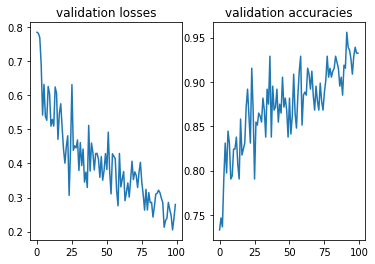

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("validation losses") 
ax1.plot(train_losses)
ax2.set_title("validation accuracies") 
ax2.plot(train_accs)

In [30]:
print(f"meta learner test")
meta_test_loss, meta_test_acc = meta_learner.meta_test(task_sets.test)


meta learner test
Meta Test Error 0.45244211982935667
Meta Test Accuracy 0.8750000074505806


In [12]:
checkpoint = {'maml_hyper_params': args,
              'state_dict': model.state_dict()}
filename = f'meta_test_accuracy_{meta_test_acc:.3f}_checkpoint.pth'
torch.save(checkpoint, filename)